In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from utils.nets import *
from utils.model_tools import *
from utils.feature_extractor import *
from utils.dataset_tools import *
from utils.cosine_similarity import *

In [2]:
# Constants
LEARNING_RATE = 0.001 # Different for CIFAR100
EXP_DECAY = 0.0001

batch_size = 64

# Files
CIFAR10_model_file = "./logs/cifar_10_cnn.pt"
FNIST_model_logan = "./logs/fnist_no_boot_bag.pt"

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))])

FMNIST_train_gen = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
FMNIST_trainloader_gen = torch.utils.data.DataLoader(FMNIST_train_gen, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

FMNIST_test_gen = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
FMNIST_testloader_gen = torch.utils.data.DataLoader(FMNIST_test_gen, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


no_boot_bag_train_idx = np.where((np.array(FMNIST_train_gen.targets) != 8) & 
                        (np.array(FMNIST_train_gen.targets) != 9))[0]
no_boot_bag_train_subset = torch.utils.data.Subset(FMNIST_train_gen, no_boot_bag_train_idx)
no_boot_bag_train_dl = torch.utils.data.DataLoader(no_boot_bag_train_subset, batch_size=batch_size, shuffle=True, num_workers=2)

no_boot_bag_test_idx = np.where((np.array(FMNIST_test_gen.targets) != 8) & 
                        (np.array(FMNIST_test_gen.targets) != 9))[0]
no_boot_bag_test_subset = torch.utils.data.Subset(FMNIST_test_gen, no_boot_bag_test_idx)
no_boot_bag_test_dl = torch.utils.data.DataLoader(no_boot_bag_test_subset, batch_size=batch_size, shuffle=True, num_workers=2)

In [4]:
class LinearFashionMNIST_alt(nn.Module):
  def __init__(self, input_size, num_classes: int):
    super(LinearFashionMNIST_alt, self).__init__()

    #self.flatten = nn.Flatten()
    self.input_layer = nn.Linear(input_size, 128)
    self.output_layer = nn.Linear(128, num_classes)

  def forward(self, x):
    #import pdb; pdb.set_trace()
    x = torch.flatten(x,1)
    x = self.input_layer(x)
    x = self.output_layer(x)
    return x

In [5]:
linear_model = LinearFashionMNIST_alt(28*28, 8)
fmnist_file = './models/linear_fashionmnist_holdout_[8, 9].pt'

linear_model.load_state_dict(torch.load(fmnist_file,map_location=torch.device('cpu')))
linear_model.eval()

LinearFashionMNIST_alt(
  (input_layer): Linear(in_features=784, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=8, bias=True)
)

In [6]:
fmnist_classes = list(range(8)) + [9]
V = get_avg_activations(linear_model,FMNIST_train_gen, fmnist_classes, ['input_layer'], 'cpu')

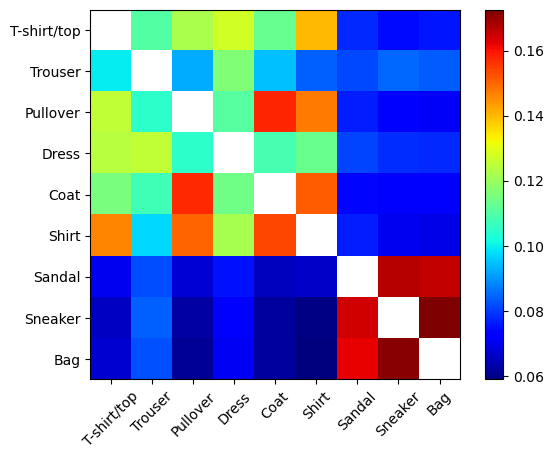

In [31]:
Vtemp = V.copy()
V[5,:] = Vtemp[6,:]; 
V[6,:] = Vtemp[5,:]; 
sm = compute_similarity_mat(V)

labs = FMNIST_train_gen.classes
labs_ = labs.copy()
labs_[5] = labs[6]; labs_[6] = labs[5]

fig, ax = plt.subplots(1,1)
img = ax.imshow(sm)
x_label_list = labs_
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(x_label_list)
ax.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(x_label_list)
plt.imshow(sm,cmap='jet')
plt.colorbar()
plt.xticks(rotation=45)

plt.savefig('fmnst_simmat')

In [32]:
# Loading general CIFAR10 trainsets/testsets
CIFAR10_train_gen = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR10_trainloader_gen = torch.utils.data.DataLoader(CIFAR10_train_gen, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

CIFAR10_test_gen = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
CIFAR10_testloader_gen = torch.utils.data.DataLoader(CIFAR10_test_gen, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

CIFAR10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# In the paper, the classes left out are 'cat' and 'car'; 'cat' is added back in later

CIFAR10_cnn = CIFAR10Cnn(8)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
linear_model = CNN_6L(8)
fmnist_file = './models/cnn_cifar10_holdout_[8, 9].pt'

linear_model.load_state_dict(torch.load(fmnist_file,map_location=torch.device('cpu')))
linear_model.eval()

CNN_6L(
  (conv_block1): Sequential(
    (Conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu1): ReLU()
    (BN1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu2): ReLU()
    (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (Conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu3): ReLU()
    (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Relu4): ReLU()
    (BN4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dila

In [34]:
def reorder_classes(dataset, new_order):
    '''
        new_order: Dict<k:INT, v:(INT, BOOL)>
            - key: Current class number
            - val[0]: New class number
            - val[1]: Swap T/F
                - T: bidirectional update between two classes ex. 1<-->3
                - F: unidirectional update ex. 1->3 3->4 4->1
        IMPORTANT: Assumes class numbers are 0-indexed
    '''

    old_indices = dict()
    unique_targets = np.unique(dataset.targets).tolist()
    all_targets = np.array(dataset.targets)
    labels = dataset.classes
    new_labels = copy(labels)

    # Gather initial target mappings
    for target in unique_targets:
        old_indices[target] = np.where(all_targets == target)[0]

    for old_target, new_target in new_order.items():
        # Assign new target value to datapoints
        np.put(all_targets, old_indices[old_target], new_target[0])
        # Update label list
        new_labels[new_target[0]] = labels[old_target]

        if new_target[1]: # Swap = True
            # Target and label update if swapping with another class
            np.put(all_targets, old_indices[new_target[0]], old_target)
            new_labels[old_target] = labels[new_target[0]]

    return all_targets.tolist(), new_labels

In [35]:
ordering = {
    0:(5, False),
    1:(9, False),
    2: (0, False),
    3: (8, False),
    4: (1, False),
    5: (2, False),
    6: (3, False),
    7: (4, False),
    8: (6, False),
    9: (7, False),
}

CIFAR10_train_gen_ro,y_ro = reorder_classes(CIFAR10_train_gen,ordering)
CIFAR10_train_gen.targets = CIFAR10_train_gen_ro
CIFAR10_train_gen.classes = y_ro

In [36]:
ccidx = [5,0,8] + list(range(1,5)) + [6,7]
V = get_avg_activations(linear_model,CIFAR10_train_gen, ccidx, ['conv_block3'], 'cpu')

In [40]:
labs = CIFAR10_train_gen.classes
labs

['bird',
 'deer',
 'dog',
 'frog',
 'horse',
 'airplane',
 'ship',
 'truck',
 'cat',
 'automobile']

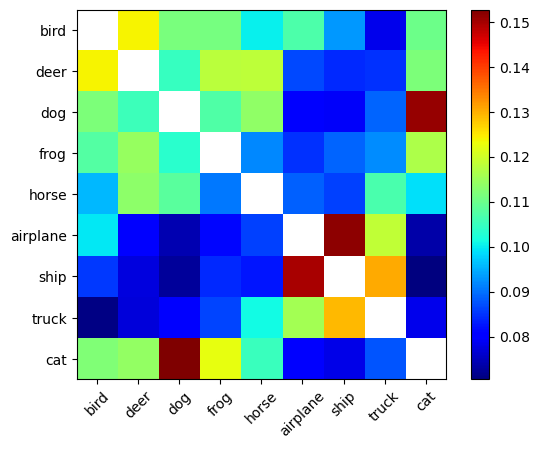

In [43]:
sm = compute_similarity_mat(V)
labs = CIFAR10_train_gen.classes
labs_ = labs.copy()
#labs_[5] = labs[6]; labs_[6] = labs[5]

fig, ax = plt.subplots(1,1)
img = ax.imshow(sm)
x_label_list = labs
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_xticklabels(x_label_list)
ax.set_yticks([0,1,2,3,4,5,6,7,8,9])
ax.set_yticklabels(x_label_list)
plt.imshow(sm,cmap='jet')
plt.colorbar()
plt.xticks(rotation=45)
plt.savefig('cfar10_simmat')

In [13]:
32*32

1024